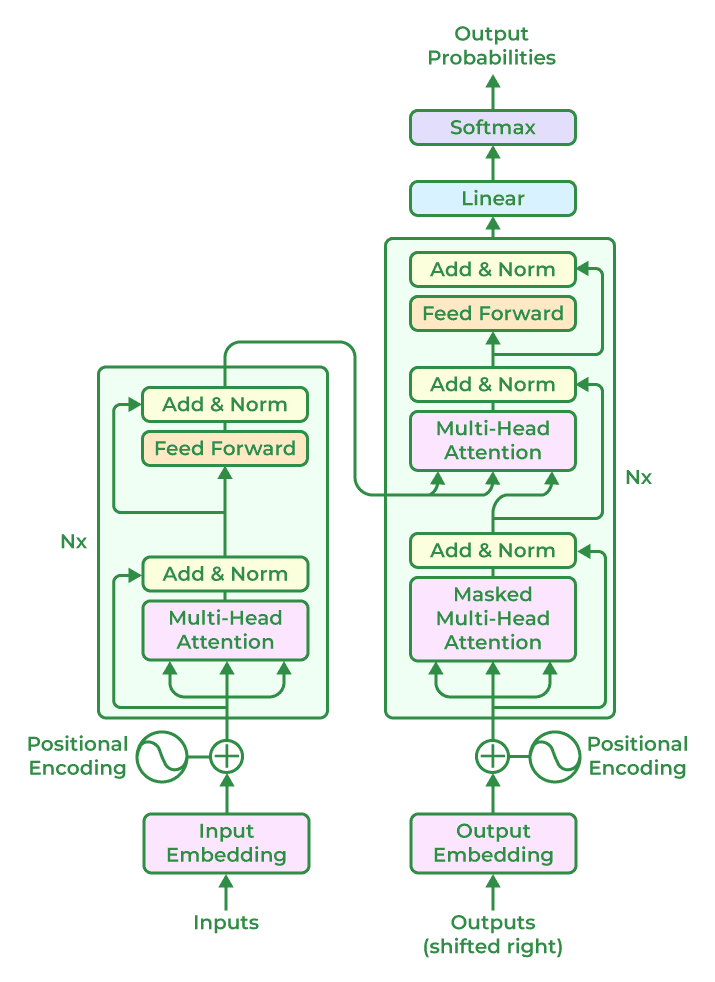



Step-by-Step Vision Transformer (ViT) Pipeline Images to Patches

* The input image(e.g. 224 X 224 X 3) is divided into fixed-size patches (e.g. 16 X 16).

* This converts the image into a sequence of small flattened grids.

* Patch Embedding:
-- Each patch is flattened into a vector and passed through a linear projection layer to embed it into a fixed-length vector(like word embedding in NLP).

* Add Positional Embeddings:
-- Since transformers have no built-in sense of order, positional embedding are added to each patch embedding to preserve spatial information.

* Add [CLS] Token:
-- A special learnable token [CLS] is prepended to the sequence. Its output after the Transformer will represent the whole image(used for classification).

* Transformer Encoder Layers
-- The sequence (patch embeddings + CLS + positional encoding) is fed into standard Transformer encoder layers:
-- Multi-Head Self-Attnetion
-- Add & Norm
-- Feed Forward Network
-- Add & Norm
-- Classification head

* The final hidden state of the [CLS] token is passed through a classification layer(typically an MLP) to produce the predicted image class.


## 1.) Import requried Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
torchvision.__version__

'0.21.0+cu124'

## 2.) Setup Device-Agnostic Code

In [4]:
!nvidia-smi

Fri Jul  4 06:07:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
torch.cuda.is_available()

True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
print(f'Using Device: {device}')

Using Device: cuda


## 3) Set the seed

In [8]:
torch.manual_seed(422)
torch.cuda.manual_seed(422)
random.seed(422)

## 4.) Setting the hyperprameters

In [9]:
BATCH_SIZE = 32 # Further reduced batch size
EPOCHS = 200
LEARNING_RATE = 3e-4
PATCH_SIZE = 8
NUM_CLASSES = 10
IMAGE_SIZE = 32 # Reduced image size to save memory
CHANNELS = 3
EMBED_DIM = 256 # Further reduced embedding dimension
NUM_HEADS = 8
DEPTH = 3 # Reduced number of Transformer layers
MLP_DIM = 128 # Adjusted MLP dimension based on new EMBED_DIM
DROP_RATE = 0.1

## 5.) Define image Transformations

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize(mean = 0.5, std = 0.5)
    # 1. Helps the model to converge faster
    # 2. Helps to make the numerical computations stable
])

transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),               # Resize to target size
    transforms.RandomCrop(size=IMAGE_SIZE, padding=4),         # Crop after padding
    transforms.RandomHorizontalFlip(),                         # Random flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.2),           # Color augmentation
    transforms.ToTensor(),                                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))                       # Normalize (make sure this matches your channel count!)
])


## 6.)Getting a dataset

In [11]:
train_dataset = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform_train
)

test_dataset = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


In [16]:
import random

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_dataset(dataset, classes):
  column = 5
  row = 5
  fig, axes = plt.subplots(row, column, figsize = (9, 9))
  for i in range(row):
    for j in range(column):
      idx = random.randint(0, len(dataset)-1) # Corrected index range
      img, label = dataset[idx]

      img = img /2 + 0.5 # unormalize our images to be able to plot them with matplotlib
      npimg = img.cpu().numpy()
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      axes[i, j].set_title(f'Label: {classes[label]}\n', fontsize =10, c = 'green')
      axes[i, j].axis('off')


  plt.tight_layout()
  plt.show()

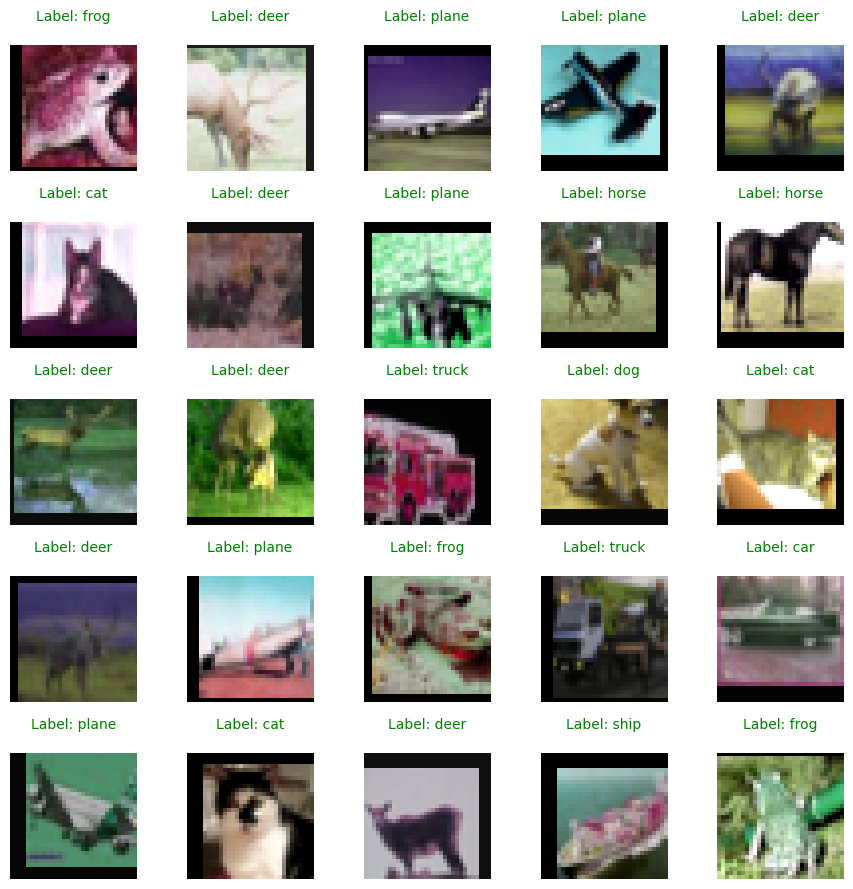

In [17]:
visualize_dataset(train_dataset, classes)

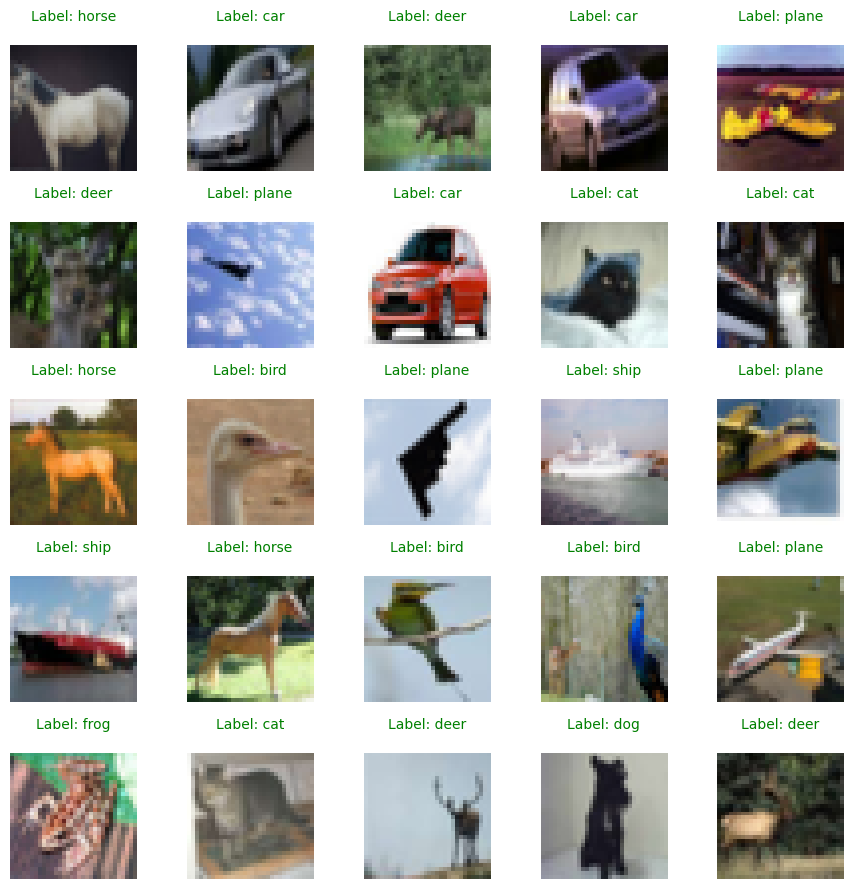

In [18]:
visualize_dataset(test_dataset, classes)

In [19]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [20]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=0.5, std=0.5)
           )

In [21]:
print(f'length of train dataset is: {len(train_dataset)}')
print(f'length of test dataset is: {len(test_dataset)}')

length of train dataset is: 50000
length of test dataset is: 10000


## 7.) Converting our dataset into dataloaders

Right now, our data is in the form of PyTorch Datasets.
DataLoader turns our data into batches or (mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memroy) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradients per epoch

In [22]:
BATCH_SIZE

32

In [23]:
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

In [24]:
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7d9bd0fc5710>, <torch.utils.data.dataloader.DataLoader object at 0x7d9bd116ee50>)
Length of train_loader: 1563 batches of 32...
Length of test_loader: 313 batches of 32...


## 9.) Building Vision Transformer Model From Scratch


In [25]:
PATCH_SIZE

8

In [26]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels = in_channels,
                          out_channels = embed_dim,
                          kernel_size= patch_size,
                          stride = patch_size)
    num_patches = (img_size // patch_size) **2 # squaring will give total patches
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

  def forward(self, x:torch.Tensor):
    #B, C, H, W = x.shape # Batch Size, Channels, Height, Width
    B = x.size(dim = 0) # Batch Size
    x = self.proj(x) #(B, E, H/P, W/P) B-->Batch size, E--> Embed_size, p-->patch_size
    x = x.flatten(start_dim = 2).transpose(1,2) # (B, E, N),N = (H/patch_size) * (W/patch_size). After transpose(1,2): (B, N, embed_dim)
    cls_tokens = self.cls_token.expand(B, -1, -1) # (B,1,embed_dim)
    x = torch.cat((cls_tokens, x), dim =1)
    x = x + self.pos_embed

    return x

In [27]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features = in_features,
                         out_features= hidden_features)
    self.fc2 = nn.Linear(in_features = hidden_features,
                         out_features = in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))

    return x



## How Multi-Head Attention Works

Multi-Head Attention is a core component of the Transformer architecture that allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, it performs the attention function multiple times in parallel with different learned linear projections of the queries, keys, and values.

Here's a breakdown of the process within a single Multi-Head Attention block:

1.  **Linear Projections:** The input tensor $X$ (shape: `(B, S, embed_dim)`) is linearly projected into Query ($Q$), Key ($K$), and Value ($V$) tensors for each head. For head $i$, the projections are:
    *   $Q_i = X W^Q_i$
    *   $K_i = X W^K_i$
    *   $V_i = X W^V_i$
    Where $W^Q_i, W^K_i, W^V_i$ are learned weight matrices for head $i$, and their dimensions are typically `(embed_dim, embed_dim / num_heads)`. $Q_i, K_i, V_i$ have shape `(B, S, embed_dim / num_heads)`.

2.  **Splitting into Heads:** (Implicit in the linear projections above, as each projection matrix is specific to a head).

3.  **Parallel Scaled Dot-Product Attention:** Each of the `num_heads` sets of ($Q_i, K_i, V_i$) is processed *in parallel* by an independent Scaled Dot-Product Attention function. For each head $i$, the attention output is calculated as:

    $\text{Attention}_i(Q_i, K_i, V_i) = \text{Softmax}(\frac{Q_i K_i^T}{\sqrt{d_k}}) V_i$

    Where $d_k = \text{embed\_dim} / \text{num\_heads}$ is the dimension of the keys and queries. The output $\text{Attention}_i$ has shape `(B, S, embed_dim / num_heads)`.

4.  **Concatenation:** The outputs from all `num_heads` parallel attention heads are then concatenated back together along the feature dimension:

    $\text{Concat} = \text{Concat}(\text{Attention}_1, \text{Attention}_2, ..., \text{Attention}_{\text{num\_heads}})$

    The concatenated tensor has shape `(B, S, embed_dim)`.

5.  **Final Linear Projection:** The concatenated output is passed through a final learned linear projection layer:

    $\text{MultiHead}(Q, K, V) = \text{Concat} W^O$

    Where $W^O$ is a learned weight matrix with shape `(embed_dim, embed_dim)`. The final output of the Multi-Head Attention block has shape `(B, S, embed_dim)`.

The output of this final linear projection is then typically added to the input via a residual connection and passed through layer normalization and the feed-forward network in a complete Transformer encoder layer.

In essence, Multi-Head Attention allows the model to capture different types of relationships and dependencies within the input sequence simultaneously by attending to different parts of the feature space through multiple heads.

In [28]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim = embed_dim,
                                      num_heads = num_heads,
                                      dropout = drop_rate,
                                      batch_first = True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp =MLP(in_features = embed_dim, hidden_features = mlp_dim, drop_rate = drop_rate)

  # x.shape --> (B, S, embed_dim) where S sequence length (cls token  number of patches)
  def forward(self, x):
    #The [0] at the end is because nn.MultiheadAttention returns a tuple where the first element is the attention output and the second is the attention weights.
    # x + self.attn(.....) to add residual connection.
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # feeding query, key and value.
    x = x + self.mlp(self.norm2(x))
    return x

In [29]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size =img_size,
                                      patch_size = patch_size,
                                      in_channels= in_channels,
                                      embed_dim = embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim = embed_dim,
                                 num_heads = num_heads,
                                 mlp_dim = mlp_dim,
                                 drop_rate = drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x) #(B, 1 + num_patches, embed_dim).
    cls_token  = x[:,0] # for all element in the batch B, select the first column,i.e. cls_token (B, embed_dim).
    return self.head(cls_token)

In [30]:
DEPTH

3

In [31]:
device

'cuda'

In [32]:
model = VisionTransformer(
    img_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    in_channels = CHANNELS,
    num_classes = NUM_CLASSES,
    embed_dim = EMBED_DIM,
    depth = DEPTH,
    num_heads = NUM_HEADS,
    mlp_dim = MLP_DIM,
    drop_rate = DROP_RATE
).to(device)

## 9.) Defining a Loss Function and an Optimizer

In [33]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE) # update our model's parameters to try and reduce loss

In [34]:
criterion

CrossEntropyLoss()

In [35]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## 10.) Defining a Training Loop Function

In [36]:
def train(model, loader, optimizer, criterion):

  # set the model into training
  model.train()

  total_loss , correct = 0,0

  for x,y in loader:

    #Moving (sending) our data into the target device
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    # 1. Forward pass (model outputs raw logits)
    out = model(x)

    # 2. calculate loss (per batch)
    loss = criterion(out, y)

    # 3. perform backpropgation
    loss.backward()

    # 4. Perform Gradient Descent
    optimizer.step()

    total_loss += loss.item() *x.size(0)

    correct += (out.argmax(1) == y).sum().item()

   # You have to scale the loss (Normlization step to make the loss general across all batches)
  return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [37]:
def evaluate(model, loader):
  model.eval() # set the mode of the model into evaluation
  correct = 0
  with torch.inference_mode():
    for x,y in loader:
      x,y = x.to(device), y.to(device)
      out = model(x)
      correct +=(out.argmax(dim =1) == y).sum().item()
  return correct/len(loader.dataset)

In [38]:
EPOCHS

200

In [39]:
from tqdm.auto import tqdm

In [ ]:
import copy

train_accuracies, test_accuracies = [], []
best_test_acc = 0.0
best_model_state = None

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}%")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Saving best model with test accuracy: {best_test_acc:.4f}%")

# Load the best model weights back
model.load_state_dict(best_model_state)
print(f"Loaded best model state with test accuracy: {best_test_acc:.4f}%")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1/200, Train loss: 1.8714, Train acc: 0.3134%, Test acc: 0.4362%
Saving best model with test accuracy: 0.4362%
Epoch: 2/200, Train loss: 1.6839, Train acc: 0.3851%, Test acc: 0.4467%
Saving best model with test accuracy: 0.4467%
Epoch: 3/200, Train loss: 1.6297, Train acc: 0.4078%, Test acc: 0.4857%
Saving best model with test accuracy: 0.4857%
Epoch: 4/200, Train loss: 1.5827, Train acc: 0.4263%, Test acc: 0.4766%
Epoch: 5/200, Train loss: 1.5527, Train acc: 0.4369%, Test acc: 0.5000%
Saving best model with test accuracy: 0.5000%
Epoch: 6/200, Train loss: 1.5183, Train acc: 0.4514%, Test acc: 0.5104%
Saving best model with test accuracy: 0.5104%
Epoch: 7/200, Train loss: 1.4816, Train acc: 0.4640%, Test acc: 0.5039%
Epoch: 8/200, Train loss: 1.4588, Train acc: 0.4740%, Test acc: 0.5191%
Saving best model with test accuracy: 0.5191%
Epoch: 9/200, Train loss: 1.4344, Train acc: 0.4818%, Test acc: 0.5269%
Saving best model with test accuracy: 0.5269%
Epoch: 10/200, Train loss: 1.4

In [35]:
train_accuracies

[0.31396,
 0.38788,
 0.41254,
 0.42604,
 0.4422,
 0.45486,
 0.46156,
 0.47082,
 0.4831,
 0.48844,
 0.49784,
 0.50344,
 0.5097,
 0.52012,
 0.52496,
 0.5328,
 0.5419,
 0.542,
 0.55062,
 0.5555,
 0.55732,
 0.56436,
 0.56922,
 0.57628,
 0.57806,
 0.58144,
 0.58618,
 0.59328,
 0.59496,
 0.59988,
 0.60296,
 0.60764,
 0.60884,
 0.6163,
 0.62,
 0.6206,
 0.62482,
 0.62776,
 0.63132,
 0.63142,
 0.63696,
 0.63962,
 0.63878,
 0.64446,
 0.6467,
 0.64738,
 0.65118,
 0.64968,
 0.65332,
 0.65572,
 0.65494,
 0.65812,
 0.66332,
 0.66442,
 0.66718,
 0.66752,
 0.66746,
 0.67312,
 0.67332,
 0.67396,
 0.67662,
 0.67996,
 0.6796,
 0.68152,
 0.68642,
 0.68052,
 0.68638,
 0.68694,
 0.69002,
 0.69388,
 0.69448,
 0.69512,
 0.6921,
 0.69632,
 0.69888,
 0.69648,
 0.70024,
 0.70084,
 0.70178,
 0.70438,
 0.70348,
 0.70756,
 0.70784,
 0.71012,
 0.71198,
 0.71414,
 0.71364,
 0.71648,
 0.7159,
 0.71752,
 0.71588,
 0.72072,
 0.72068,
 0.72102,
 0.72466,
 0.72634,
 0.72658,
 0.72604,
 0.72704,
 0.72786]

In [34]:
test_accuracies

[0.4309,
 0.454,
 0.4623,
 0.4813,
 0.4949,
 0.5025,
 0.516,
 0.5308,
 0.5326,
 0.5355,
 0.5409,
 0.5579,
 0.5613,
 0.5629,
 0.562,
 0.5759,
 0.5778,
 0.5889,
 0.5738,
 0.5895,
 0.6044,
 0.6002,
 0.61,
 0.6119,
 0.6112,
 0.6123,
 0.6223,
 0.6385,
 0.6354,
 0.6345,
 0.6402,
 0.6389,
 0.6502,
 0.6493,
 0.6454,
 0.662,
 0.6616,
 0.6635,
 0.6707,
 0.6554,
 0.6658,
 0.6734,
 0.6697,
 0.6764,
 0.6747,
 0.6724,
 0.6837,
 0.6849,
 0.6796,
 0.6865,
 0.682,
 0.6916,
 0.6928,
 0.6944,
 0.6923,
 0.698,
 0.696,
 0.7015,
 0.7032,
 0.7052,
 0.7043,
 0.7039,
 0.7016,
 0.7016,
 0.7096,
 0.7096,
 0.7158,
 0.7179,
 0.7156,
 0.716,
 0.7178,
 0.7173,
 0.7181,
 0.7258,
 0.7226,
 0.7239,
 0.7276,
 0.7249,
 0.7305,
 0.7291,
 0.7268,
 0.7303,
 0.7229,
 0.73,
 0.7339,
 0.7344,
 0.7416,
 0.7404,
 0.7366,
 0.7317,
 0.7323,
 0.7348,
 0.7422,
 0.7421,
 0.7471,
 0.7441,
 0.7506,
 0.7419,
 0.7481,
 0.7483]

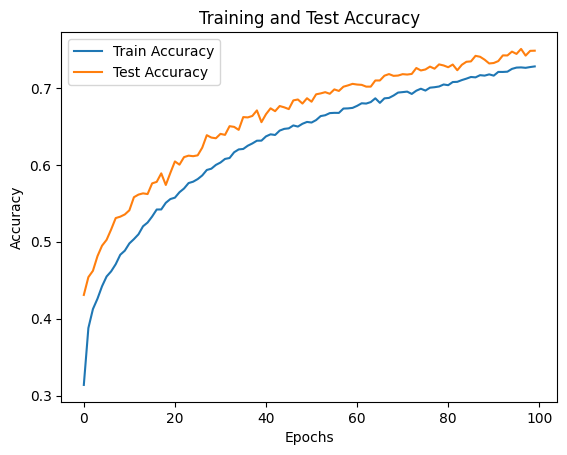

In [36]:
# plot accuracy
plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

In [37]:
print(len(test_dataset))

10000


In [38]:
test_dataset[0][0].unsqueeze(dim =0).shape

torch.Size([1, 3, 32, 32])

In [39]:
test_dataset[0][0]/2 +0.5

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [47]:
def predict_and_plot_grid(model, dataset, classes, grid_size =3):
  model.eval()
  fig, axes = plt.subplots( grid_size, grid_size, figsize= (9,9))

  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset)-1)
      img , true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim =0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
      img = img /2 + 0.5 # unormalize our images to be able to plot them with matplotlib
      npimg = img.cpu().numpy()
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = 'r'
      axes[i, j].set_title(f'Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}', fontsize =10, c = color)
      axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

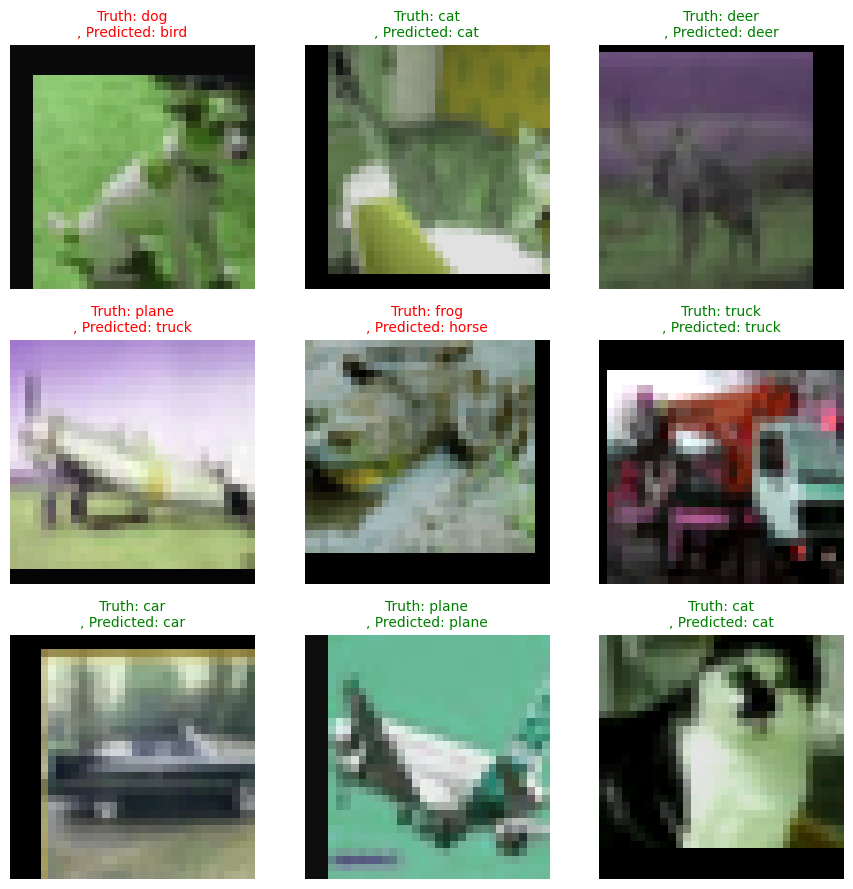

In [51]:
predict_and_plot_grid(model, train_dataset,classes )

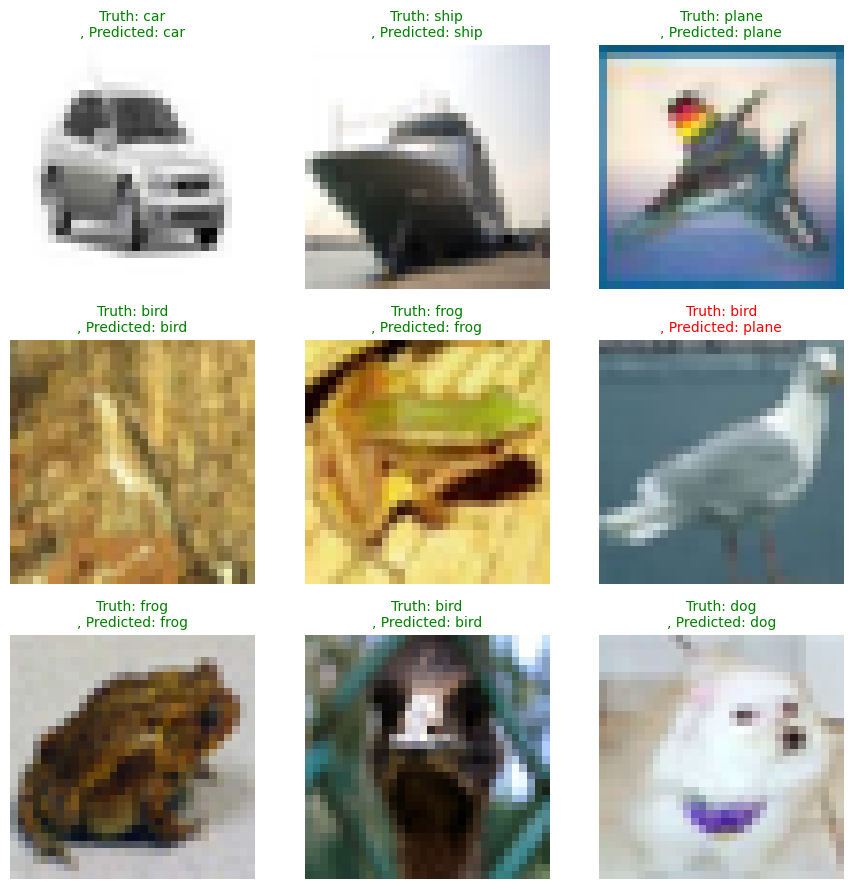

In [50]:
predict_and_plot_grid(model, test_dataset, classes)

You can save the best model's state dictionary to a file using `torch.save()` and then download the file.

In [52]:
# Define a filename for your model weights
model_filename = "best_vit_model(with best test accuracy ).pth"

# Save the best model state dictionary
torch.save(best_model_state, model_filename)

print(f"Best model weights saved to {model_filename}")

Best model weights saved to best_vit_model(with best test accuracy 0.7506%).pth
